In [25]:
!pip install -q "pinecone~=7.3.0" "pinecone-plugin-records" datasets==3.5.1 openai semantic-text-splitter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.4/267.4 kB 7.3 MB/s eta 0:00:00


In [26]:
from google.colab import drive, userdata
import os
from pinecone import Pinecone
from openai import OpenAI

# ---- 1. Try mounting Google Drive ----
try:
    drive.mount("/content/drive")
    DRIVE_MOUNTED = True
    print("✅ Google Drive mounted at /content/drive")
except Exception as e:
    DRIVE_MOUNTED = False
    print("⚠️ Could not mount Google Drive. Continuing without it.")
    print("Error:", e)

# ---- 2. (Optional) change to your working folder on Drive ----
if DRIVE_MOUNTED:
    # 👇 change this path if you use a different folder name
    WORKDIR = "/content/drive/My Drive/AIBiz/SellerSight"
    os.makedirs(WORKDIR, exist_ok=True)
    os.chdir(WORKDIR)
    print("Working directory:", os.getcwd())
else:
    print("Using Colab local storage only (files won’t persist after runtime reset).")

# ---- 3. Connect to Pinecone & OpenAI using Colab secrets ----
PINECONE_API_KEY = userdata.get("PINECONE_API_KEY")
OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")

if not PINECONE_API_KEY or not OPENAI_API_KEY:
    raise ValueError("❌ Missing PINECONE_API_KEY or OPENAI_API_KEY in Colab secrets.")

pc = Pinecone(api_key=PINECONE_API_KEY)
openai = OpenAI(api_key=OPENAI_API_KEY)

print("✅ Connected to Pinecone & OpenAI")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted at /content/drive
Working directory: /content/drive/My Drive/AIBiz/SellerSight
✅ Connected to Pinecone & OpenAI


In [27]:
INDEX_NAME = "sellersight-reviews"   # <- use the name used in your MyAI3 config.ts

if not pc.has_index(INDEX_NAME):
    pc.create_index_for_model(
        name=INDEX_NAME,
        cloud="aws",
        region="us-east-1",
        embed={
            "model": "llama-text-embed-v2",
            "field_map": {"text": "chunk_text"},
        },
    )
    print(f"Created Pinecone index: {INDEX_NAME}")
else:
    print(f"Using existing Pinecone index: {INDEX_NAME}")

index = pc.Index(name=INDEX_NAME)

Using existing Pinecone index: sellersight-reviews


In [28]:
import requests

CATEGORIES_URL = (
    "https://huggingface.co/datasets/"
    "McAuley-Lab/Amazon-Reviews-2023/resolve/main/all_categories.txt"
)

resp = requests.get(CATEGORIES_URL)
resp.raise_for_status()

raw_lines = resp.text.strip().splitlines()
categories = [line.strip() for line in raw_lines if line.strip()]

# Map internal IDs -> pretty display names (remove underscores)
id_to_display = {cat: cat.replace("_", " ") for cat in categories}

print("Available categories:\n")
for i, (cat_id, display) in enumerate(id_to_display.items(), start=1):
    print(f"{i:2d}. {display}")

print("\n(You can also type 'others' to use a generic mixed category.)")

def select_others():
    """Return the internal id for generic 'Others'."""
    if "Unknown" in categories:
        return "Unknown"
    return categories[-1]

def find_exact_and_suggestions(name: str):
    """Return (exact_id or None, suggestions list of display names)."""
    name_norm = name.strip().lower().replace("_", " ")

    # Exact match on display name
    for cid, disp in id_to_display.items():
        if disp.lower() == name_norm:
            return cid, []

    # Partial matches
    suggestions = [
        disp
        for cid, disp in id_to_display.items()
        if name_norm in disp.lower()
    ]
    return None, suggestions

selected_category = None

while selected_category is None:
    choice = input("\nType category number, exact name, or 'others': ").strip()

    # ---- others ----
    if choice.lower() == "others":
        selected_category = select_others()
        print("\nUsing generic 'Others' category:", id_to_display[selected_category])
        break

    # ---- numeric choice ----
    if choice.isdigit():
        idx = int(choice)
        if 1 <= idx <= len(id_to_display):
            selected_category = list(id_to_display.keys())[idx - 1]
            print("\nSelected category:", id_to_display[selected_category])
            break
        else:
            print("Invalid number. Please choose a number from the list or type 'others'.")
            continue

    # ---- name-based choice (case-insensitive) ----
    exact_id, suggestions = find_exact_and_suggestions(choice)

    if exact_id:
        selected_category = exact_id
        print("\nSelected category:", id_to_display[selected_category])
        break

    # No exact match → show suggestions but DO NOT lock the user in
    if suggestions:
        print("\nCould not find an exact category match for:", choice)
        print("Possible matches:")
        for s in suggestions:
            print(f"- {s}")
        print("Please type one of these names exactly, a number from the main list, or 'others'.")
    else:
        print(
            "\nNo similar category found. Please type one of the listed category "
            "names, its number, or 'others'."
        )
    # loop continues until user enters a valid choice or 'others'

print("\nFinal selected category ID (internal):", selected_category)
print("Final selected category (display):", id_to_display[selected_category])


Available categories:

 1. All Beauty
 2. Toys and Games
 3. Cell Phones and Accessories
 4. Industrial and Scientific
 5. Gift Cards
 6. Musical Instruments
 7. Electronics
 8. Handmade Products
 9. Arts Crafts and Sewing
10. Baby Products
11. Health and Household
12. Office Products
13. Digital Music
14. Grocery and Gourmet Food
15. Sports and Outdoors
16. Home and Kitchen
17. Subscription Boxes
18. Tools and Home Improvement
19. Pet Supplies
20. Video Games
21. Kindle Store
22. Clothing Shoes and Jewelry
23. Patio Lawn and Garden
24. Unknown
25. Books
26. Automotive
27. CDs and Vinyl
28. Beauty and Personal Care
29. Amazon Fashion
30. Magazine Subscriptions
31. Software
32. Health and Personal Care
33. Appliances
34. Movies and TV

(You can also type 'others' to use a generic mixed category.)

Type category number, exact name, or 'others': 1

Selected category: All Beauty

Final selected category ID (internal): All_Beauty
Final selected category (display): All Beauty


In [29]:
from datasets import load_dataset
import pandas as pd

review_config = f"raw_review_{selected_category}"
meta_config   = f"raw_meta_{selected_category}"

# ---- Load and clean reviews ----
reviews_ds = load_dataset(
    "McAuley-Lab/Amazon-Reviews-2023",
    review_config,
    trust_remote_code=True,
)
reviews_full = reviews_ds["full"]

MAX_REVIEWS = 100_000
if len(reviews_full) > MAX_REVIEWS:
    reviews_sample = reviews_full.shuffle(seed=42).select(range(MAX_REVIEWS))
else:
    reviews_sample = reviews_full

reviews_df = pd.DataFrame(reviews_sample)
reviews_df = reviews_df.dropna(subset=["text"])
reviews_df = reviews_df[reviews_df["text"].str.len() > 60].copy()

keep_cols = ["asin", "parent_asin", "rating", "title",
             "text", "timestamp", "verified_purchase", "helpful_vote"]
reviews_df = reviews_df[keep_cols]
reviews_df["helpful_vote"] = reviews_df["helpful_vote"].fillna(0).astype(int)

print("Shape after cleaning:", reviews_df.shape)
reviews_df.head()

# ---- Load metadata ----
print("\nLoading item metadata for config:", meta_config)

meta_ds = load_dataset(
    "McAuley-Lab/Amazon-Reviews-2023",
    meta_config,
    split="full",
    trust_remote_code=True,
)
meta_df = pd.DataFrame(meta_ds)

# ---- Build product_summary (per parent_asin) ----
product_stats = (
    reviews_df
    .groupby("parent_asin")
    .agg(
        num_reviews=("rating", "count"),
        avg_rating=("rating", "mean"),
    )
    .reset_index()
)

meta_cols = ["parent_asin", "title", "store", "price", "main_category"]
meta_subset = meta_df[meta_cols].drop_duplicates("parent_asin")

product_summary = (
    product_stats
    .merge(meta_subset, on="parent_asin", how="left")
    .sort_values("num_reviews", ascending=False)
    .reset_index(drop=True)
)

product_summary["avg_rating"] = product_summary["avg_rating"].round(2)

print("\nTop products in this category by #reviews:\n")
product_summary[[
    "parent_asin",
    "title",
    "store",
    "price",
    "avg_rating",
    "num_reviews",
]].head(20)


Shape after cleaning: (66818, 8)

Loading item metadata for config: raw_meta_All_Beauty


raw/meta_categories/meta_All_Beauty.json(…):   0%|          | 0.00/213M [00:00<?, ?B/s]

Generating full split:   0%|          | 0/112590 [00:00<?, ? examples/s]


Top products in this category by #reviews:



,parent_asin,title,store,price,avg_rating,num_reviews
0,B085BB7B1M,Salux Nylon Japanese Beauty Skin Bath Wash Clo...,SALUX,12.99,4.63,221
1,B0BM4GX6TT,"Godefroy Tint Kit for Spot Coloring, Dark Brown",Godefroy,24.95,4.21,201
2,B019GBG0IE,Collapsible Hair Diffuser by The Curly Co. wit...,The Curly Co.,16.99,3.56,147
3,B07C533XCW,Segbeauty empty bottle 160083,Segbeauty,None,4.39,132
4,B00R1TAN7I,GranNaturals Boar Bristle Smoothing Hair Brush...,GranNaturals,12.99,3.95,130
5,B08L5KN7X4,Meeteasy Dental Cleaner Tool Kit - Dental Care...,Meeteasy,24.97,3.97,124
6,B01M1OFZOG,Bed Head Curve Check Curling Wand for Tousled ...,Bed Head,27.99,3.88,123
7,B09X9BG4FC,Makone Crystal Crowns and Tiaras with Comb Hea...,Makone,9.99,4.33,109
8,B005BZQHEC,Gauge Gear Ear Stretching Balm | 10 ml Jar | P...,Gauge Gear,9.99,4.83,109
9,B01N4885PD,"Helen of Troy 1511 Brush Iron, White, 3/4 Inch...",Helen Of Troy,16.3,3.43,95


In [30]:
# Cell 4 – Choose YOUR ASIN inside this category (with fallback)

def child_asins_for_parent(pid):
    return sorted(
        reviews_df.loc[reviews_df["parent_asin"] == pid, "asin"].unique().tolist()
    )

MY_PARENT = None
MY_ASIN = None

asin_input = input("\nEnter the ASIN of the product you want to analyse: ").strip()

# Try to find as child ASIN
mask_child = reviews_df["asin"] == asin_input

if mask_child.any():
    MY_ASIN = asin_input
    MY_PARENT = (
        reviews_df.loc[mask_child, "parent_asin"]
        .value_counts()
        .index[0]
    )
    print("\n✅ Found this ASIN in the selected category.")
    row = product_summary[product_summary["parent_asin"] == MY_PARENT].head(1)
    print("Product details:")
    print(row[["parent_asin", "title", "avg_rating", "num_reviews"]].to_string(index=False))

else:
    print(
        f"\n⚠️ ASIN '{asin_input}' not found in the loaded dataset for this category.\n"
        "For the demo, please pick a product from this category instead."
    )

    top_table = product_summary[[
        "parent_asin", "title", "avg_rating", "num_reviews"
    ]].head(20)

    print("\nTop products in this category (use row index):\n")
    print(top_table.to_string(index=True))

    while True:
        row_input = input("\nEnter ONE row index for YOUR product (e.g. 0): ").strip()
        if row_input.isdigit():
            i = int(row_input)
            if 0 <= i < len(product_summary):
                MY_PARENT = product_summary.loc[i, "parent_asin"]
                row = product_summary.loc[[i], [
                    "parent_asin", "title", "avg_rating", "num_reviews"
                ]]
                print("\nChosen product:")
                print(row.to_string(index=False))
                break
        print("Please enter a valid row index from the table above.")

    kids = child_asins_for_parent(MY_PARENT)
    print("\nChild ASINs for this product:\n", kids)

    while True:
        MY_ASIN = input("Pick ONE ASIN from this list for analysis: ").strip()
        if MY_ASIN in kids:
            break
        print("That ASIN is not in the list. Please choose from:", kids)

print("\nFinal selection:")
print("Parent (product) ID:", MY_PARENT)
print("Child ASIN chosen for analysis:", MY_ASIN)

df_my = reviews_df[reviews_df["asin"] == MY_ASIN].copy()
print("\nNumber of reviews for your chosen ASIN:", len(df_my))
df_my.head()



Enter the ASIN of the product you want to analyse: B00YQ6X8EO

✅ Found this ASIN in the selected category.
Product details:
parent_asin                                                               title  avg_rating  num_reviews
 B00YQ6X8EO Herbivore - Natural Sea Mist Texturizing Salt Spray (Coconut, 8 oz)         4.2           10

Final selection:
Parent (product) ID: B00YQ6X8EO
Child ASIN chosen for analysis: B00YQ6X8EO

Number of reviews for your chosen ASIN: 10


,asin,parent_asin,rating,title,text,timestamp,verified_purchase,helpful_vote
4373,B00YQ6X8EO,B00YQ6X8EO,5.0,Herbivore coconut sea mist is literally the be...,I've gone through something like four bottles ...,1478579127000,True,2
7959,B00YQ6X8EO,B00YQ6X8EO,4.0,Color and scent change after a while,I !ike the scent and the way it makes me feel....,1571679022042,True,2
12268,B00YQ6X8EO,B00YQ6X8EO,5.0,"Lightweight, easy to apply, and smells great",I am a big fan of the glass bottle; I know tha...,1631812711905,True,0
35604,B00YQ6X8EO,B00YQ6X8EO,5.0,Great product,This product is great but a little pricey for ...,1581027190229,True,0
36020,B00YQ6X8EO,B00YQ6X8EO,5.0,good for the curls,I have curly hair and this product really help...,1500845718233,True,2


In [31]:
# === Cell 5 – Select competitors (optional) and build df_focus in the right order ===

all_parent_ids = [MY_PARENT]
product_label_map = {MY_PARENT: "MY_PRODUCT"}

want_comp = input(
    "\nDo you also want competitor analysis for this product? (y/n): "
).strip().lower()

competitor_parent_ids = []
competitor_indices = []  # keep the exact order user typed

if want_comp == "y":
    print("\nPotential competitor products in this category:\n")
    competitors_table = (
        product_summary[product_summary["parent_asin"] != MY_PARENT][[
            "parent_asin", "title", "avg_rating", "num_reviews"
        ]]
        .head(30)
    )
    print(competitors_table.to_string(index=True))

    comp_input = input(
        "\nEnter one or more row indices for competitor products "
        "(comma-separated, e.g. 1,3,5). You can choose multiple, or leave blank for none: "
    ).strip()

    if comp_input:
        # keep user order: e.g. '29,1,3' stays [29, 1, 3]
        comp_indices = [
            int(x.strip())
            for x in comp_input.split(",")
            if x.strip().isdigit()
        ]

        for idx in comp_indices:
            if 0 <= idx < len(product_summary):
                pid = product_summary.loc[idx, "parent_asin"]
                if pid != MY_PARENT and pid not in competitor_parent_ids:
                    competitor_parent_ids.append(pid)
                    competitor_indices.append(idx)

# Label competitors as COMP_1, COMP_2, ... **in the order user provided**
for j, pid in enumerate(competitor_parent_ids, start=1):
    label = f"COMP_{j}"
    product_label_map[pid] = label
    all_parent_ids.append(pid)

# --- Show a clean info table for MY_PRODUCT + competitors ---

summary_rows = []

# Helper to get row from product_summary
def get_product_row(pid):
    row = product_summary[product_summary["parent_asin"] == pid].head(1)
    if row.empty:
        return {"parent_asin": pid, "title": "N/A", "avg_rating": None,
                "num_reviews": None, "price": None, "store": None}
    r = row.iloc[0]
    return {
        "parent_asin": pid,
        "title": r.get("title", "N/A"),
        "store": r.get("store", "N/A"),
        "price": r.get("price", None),
        "avg_rating": r.get("avg_rating", None),
        "num_reviews": r.get("num_reviews", None),
    }

# First: your product
info_my = get_product_row(MY_PARENT)
info_my["label"] = "MY_PRODUCT"
summary_rows.append(info_my)

# Then: competitors in the same order you typed
for j, pid in enumerate(competitor_parent_ids, start=1):
    info_c = get_product_row(pid)
    info_c["label"] = f"COMP_{j}"
    summary_rows.append(info_c)

products_info_df = pd.DataFrame(summary_rows)[[
    "label", "parent_asin", "title", "store", "price", "avg_rating", "num_reviews"
]]

print("\n=== Products selected for analysis (in order) ===\n")
print(products_info_df.to_string(index=False))

# --- Build df_focus with reviews for MY_PRODUCT + competitors ---

df_focus = reviews_df[reviews_df["parent_asin"].isin(all_parent_ids)].copy()
df_focus["which_product"] = df_focus["parent_asin"].map(product_label_map)

print("\nReview counts per chosen product (same label order as above):")
counts = df_focus.groupby("which_product")["rating"].count()

# enforce the order: MY_PRODUCT, COMP_1, COMP_2, ...
ordered_labels = [row["label"] for row in summary_rows]
for lbl in ordered_labels:
    print(f"{lbl}: {counts.get(lbl, 0)} reviews")

# peek at a few rows
df_focus.head()



Do you also want competitor analysis for this product? (y/n): y

Potential competitor products in this category:

   parent_asin                                                                                                                                                                                      title  avg_rating  num_reviews
0   B085BB7B1M                                                                                                            Salux Nylon Japanese Beauty Skin Bath Wash Cloth/towel (3) Blue Yellow and Pink        4.63          221
1   B0BM4GX6TT                                                                                                                                            Godefroy Tint Kit for Spot Coloring, Dark Brown        4.21          201
2   B019GBG0IE                                                                                                       Collapsible Hair Diffuser by The Curly Co. with The Curly Co. Satisfaction Guarantee   

,asin,parent_asin,rating,title,text,timestamp,verified_purchase,helpful_vote,which_product
1065,B007IAE5WY,B085BB7B1M,5.0,Really cleans the dirt,These towels are amazing they really clean the...,1527045687838,True,0,COMP_1
1407,B007IAE5WY,B085BB7B1M,5.0,to me good product,"For me this product works very well, the fabri...",1408429215000,True,1,COMP_1
1435,B007IAE5WY,B085BB7B1M,5.0,skin feels good,love the way these make my skin feel after a s...,1369605409000,True,0,COMP_1
1650,B007IAE5WY,B085BB7B1M,5.0,Great wash cloths. Will last a long time!,I love these things. To me they are so much be...,1435358254000,True,0,COMP_1
1813,B007IAE5WY,B085BB7B1M,5.0,Very scrubby!,I love these Japanese cleansing cloths. These...,1509404978791,True,0,COMP_1



=== Competitive Analysis Metrics ===



,Label,ASIN,Title,Reviews/month,Avg rating L12M,Sentiment score,% recent reviews,Value score,Rating distribution,Top praise,Top complaints
0,MY_PRODUCT,B00YQ6X8EO,Herbivore - Natural Sea Mist Texturizing Salt ...,300.0,4.20,1.20,100.0,NaN,20.0% 1–2★ / 0.0% 3★ / 80.0% 4–5★,I've gone through something like four bottles ...,"it didnt add shine, it didnt hold a style, it ..."
1,COMP_1,B085BB7B1M,Salux Nylon Japanese Beauty Skin Bath Wash Clo...,6630.0,4.63,1.63,100.0,0.3563,5.4% 1–2★ / 5.4% 3★ / 89.1% 4–5★,"I LOVE, LOVE, LOVE these.<br /><br />This wash...",I’ve been using these for years and usually or...


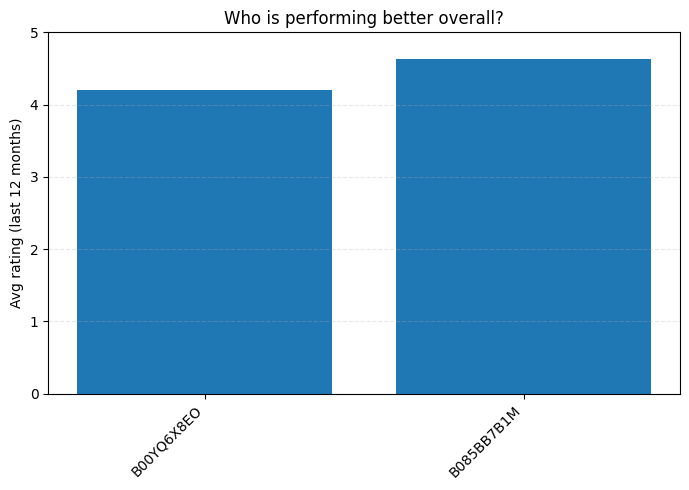

In [32]:
# === Updated Cell – Competitive Analysis w/Title + ASIN + Better Chart ===

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display as ipy_display

# Ensure competitor list exists
try:
    competitor_parent_ids
except NameError:
    competitor_parent_ids = []

# Fix timestamps safely
lower = 1_000_000_000
upper = 2_000_000_000
df_focus["timestamp"] = pd.to_numeric(df_focus["timestamp"], errors="coerce")
df_focus["timestamp"] = df_focus["timestamp"].clip(lower, upper)
df_focus = df_focus.dropna(subset=["timestamp"])
df_focus["dt"] = pd.to_datetime(df_focus["timestamp"], unit="s", errors="coerce")
df_focus = df_focus.dropna(subset=["dt"])

max_date = df_focus["dt"].max()
cutoff_12m = max_date - pd.DateOffset(months=12)

# Ordered list
labels_and_parents = [("MY_PRODUCT", MY_PARENT)]
for j, pid in enumerate(competitor_parent_ids, start=1):
    labels_and_parents.append((f"COMP_{j}", pid))

metric_rows = []

for label, pid in labels_and_parents:
    df_p = df_focus[df_focus["parent_asin"] == pid]
    if df_p.empty:
        continue

    df_recent = df_p[df_p["dt"] >= cutoff_12m]
    total = len(df_p)
    days_span = max((df_p["dt"].max() - df_p["dt"].min()).days, 1)
    reviews_month = total / (days_span/30)

    avg12 = df_recent["rating"].mean()
    if np.isnan(avg12): avg12 = df_p["rating"].mean()

    sentiment = (df_p["rating"] - 3).mean()
    pct_recent = 100 * len(df_recent) / total

    meta_info = product_summary[product_summary["parent_asin"] == pid].head(1)
    title = meta_info.iloc[0].get("title", "N/A") if not meta_info.empty else "N/A"
    asin = pid

    price = meta_info.iloc[0].get("price", np.nan) if not meta_info.empty else np.nan
    try: price = float(price)
    except: price = np.nan
    value_score = avg12 / price if price and price>0 else np.nan

    low = (df_p["rating"]<=2).sum()/total*100
    mid = (df_p["rating"]==3).sum()/total*100
    high = (df_p["rating"]>=4).sum()/total*100
    rating_dist = f"{low:.1f}% 1–2★ / {mid:.1f}% 3★ / {high:.1f}% 4–5★"

    praise = df_p[df_p["rating"]>=4].sort_values("helpful_vote",ascending=False)
    praise = praise.iloc[0]["text"][:160].replace("\n"," ") if not praise.empty else "—"

    complaint = df_p[df_p["rating"]<=2].sort_values("helpful_vote",ascending=False)
    complaint = complaint.iloc[0]["text"][:160].replace("\n"," ") if not complaint.empty else "—"

    metric_rows.append({
        "Label": label,
        "ASIN": asin,
        "Title": title,
        "Reviews/month": round(reviews_month, 2),
        "Avg rating L12M": round(avg12, 2),
        "Sentiment score": round(sentiment, 2),
        "Top praise": praise,
        "Top complaints": complaint,
        "% recent reviews": round(pct_recent, 1),
        "Value score": round(value_score, 4) if not np.isnan(value_score) else np.nan,
        "Rating distribution": rating_dist,
    })

metrics_df = pd.DataFrame(metric_rows)

print("\n=== Competitive Analysis Metrics ===\n")
ipy_display(metrics_df[
    ["Label","ASIN","Title","Reviews/month","Avg rating L12M",
     "Sentiment score","% recent reviews","Value score",
     "Rating distribution","Top praise","Top complaints"]
])

# --- Chart with ASINs ---
plt.figure(figsize=(7,5))
plt.bar(metrics_df["ASIN"], metrics_df["Avg rating L12M"])
plt.ylim(0,5)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Avg rating (last 12 months)")
plt.title("Who is performing better overall?")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

In [42]:
# === Attach product Title + ASIN to df_focus for readability ===

product_info_cols = ["parent_asin", "title"]
product_info = product_summary[product_info_cols].drop_duplicates("parent_asin")

df_focus = df_focus.merge(product_info, on="parent_asin", how="left")

In [45]:
# Define 'is_complaint' and create 'df_novel' from 'df_focus'
df_focus["is_complaint"] = df_focus["rating"] <= 2
df_novel = df_focus[df_focus["is_complaint"]].copy()


ROOT_CAUSE_TOPICS = {
    "battery_life": ["battery","drain","charge","charging","power"],
    "performance_speed": ["slow","lag","freeze","hang","performance"],
    "build_quality": ["broke","broken","crack","hinge","build","flimsy"],
    "overheating": ["heat","hot","overheat","temperature"],
    "delivery_packaging": ["delivery","package","damaged","late","delay"],
    "price_value": ["expensive","overpriced","value","cheap"],
    "customer_support": ["support","service","refund","replacement","return"],
}

def tag_root_causes(text):
    if not isinstance(text,str):
        return []
    t = text.lower()
    matched=[]
    for topic,keys in ROOT_CAUSE_TOPICS.items():
        if any(k in t for k in keys):
            matched.append(topic)
    return matched

df_novel["root_causes"] = df_novel.apply(
    lambda r: tag_root_causes(r["title_y"] + " " + r["text"]) if r["is_complaint"] else [],
    axis=1
)

exploded = df_novel.explode("root_causes")
exploded = exploded[exploded["root_causes"].notna() & (exploded["root_causes"]!="")]

root_cause_stats = (
    exploded.groupby(["title_y","parent_asin","which_product","root_causes"]) # 'title' here is now the product title
    .size()
    .reset_index(name="complaint_count")
)

total_per_prod = root_cause_stats.groupby("which_product")["complaint_count"].transform("sum")
root_cause_stats["share_of_complaints_%"] = (
    root_cause_stats["complaint_count"] / total_per_prod * 100
).round(1)

root_cause_stats = root_cause_stats.sort_values(
    ["which_product","complaint_count"], ascending=[True,False]
)

print("\n=== Root Cause Complaint Priorities ===\n")
ipy_display(root_cause_stats)

print("\n=== Top Issues for MY_PRODUCT ===\n")
ipy_display(
    root_cause_stats[root_cause_stats["which_product"]=="MY_PRODUCT"]
    .head(10)
    .reset_index(drop=True)
)



=== Root Cause Complaint Priorities ===



,title_y,parent_asin,which_product,root_causes,complaint_count,share_of_complaints_%
1,Salux Nylon Japanese Beauty Skin Bath Wash Clo...,B085BB7B1M,COMP_1,customer_support,4,57.1
3,Salux Nylon Japanese Beauty Skin Bath Wash Clo...,B085BB7B1M,COMP_1,price_value,2,28.6
2,Salux Nylon Japanese Beauty Skin Bath Wash Clo...,B085BB7B1M,COMP_1,performance_speed,1,14.3
0,Herbivore - Natural Sea Mist Texturizing Salt ...,B00YQ6X8EO,MY_PRODUCT,price_value,1,100.0



=== Top Issues for MY_PRODUCT ===



,title_y,parent_asin,which_product,root_causes,complaint_count,share_of_complaints_%
0,Herbivore - Natural Sea Mist Texturizing Salt ...,B00YQ6X8EO,MY_PRODUCT,price_value,1,100.0



=== Monthly complaint counts for MY_PRODUCT ===



,month,root_causes,title,parent_asin,complaint_count
0,2033-05-01,price_value,Herbivore - Natural Sea Mist Texturizing Salt ...,B00YQ6X8EO,1


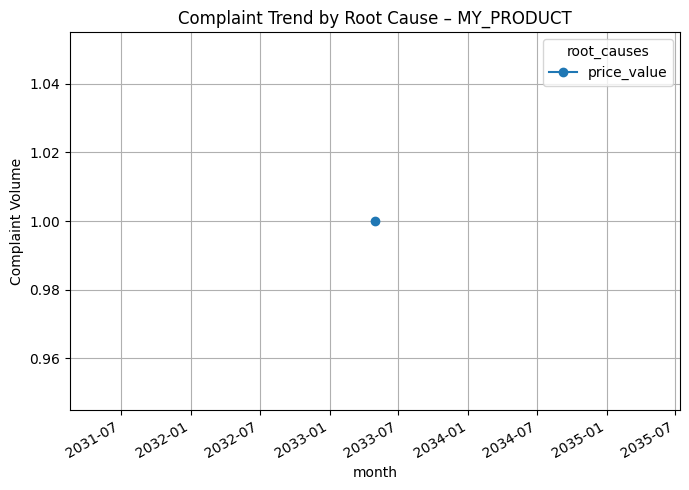

In [46]:
# === Complaint Trend Over Time (by Root Cause) for MY_PRODUCT ===

trend_df = exploded[
    (exploded["is_complaint"]) &
    (exploded["root_causes"].notna()) &
    (exploded["which_product"] == "MY_PRODUCT")
].copy()

trend_df["timestamp"] = pd.to_numeric(trend_df["timestamp"], errors="coerce")
mask = (trend_df["timestamp"] >= 1_000_000_000) & (trend_df["timestamp"] <= 2_000_000_000)
trend_df = trend_df[mask]

trend_df["date"] = pd.to_datetime(trend_df["timestamp"], unit="s")
trend_df["month"] = trend_df["date"].dt.to_period("M").dt.to_timestamp()

# Ensure 'title' column in trend_df contains the product title (from product_summary)
# This is a defensive merge to ensure the product title is always present for grouping
product_info_cols = ["parent_asin", "title"]
product_info_for_merge = product_summary[product_info_cols].drop_duplicates("parent_asin")
trend_df = trend_df.merge(product_info_for_merge, on="parent_asin", how="left", suffixes=('_review_orig', ''))

# Handle potential column conflicts if 'title' (review title) was still present and renamed
# If a 'title_review_orig' column exists, it means the original 'title' (review title) was present.
# We want the merged 'title' to be the product title, and if needed, rename the old one.
if 'title_review_orig' in trend_df.columns and 'review_title' not in trend_df.columns:
    # If 'review_title' isn't explicitly set, move the original review title there
    trend_df.rename(columns={'title_review_orig': 'review_title'}, inplace=True)
elif 'title_review_orig' in trend_df.columns and 'review_title' in trend_df.columns:
    # If both exist, the original 'review_title' should be from df_novel
    # and 'title_review_orig' is the old 'title' from df_focus. Drop the redundant one.
    trend_df.drop(columns=['title_review_orig'], inplace=True)


monthly_counts = (
    trend_df.groupby(["month","root_causes","title","parent_asin"])
    .size()
    .reset_index(name="complaint_count")
)

print("\n=== Monthly complaint counts for MY_PRODUCT ===\n")
ipy_display(monthly_counts.head())

N_TOP = 4
top_topics = (
    monthly_counts.groupby("root_causes")["complaint_count"].sum()
    .sort_values(ascending=False)
    .head(N_TOP)
    .index
)

pivot = monthly_counts[monthly_counts["root_causes"].isin(top_topics)] \
    .pivot(index="month", columns="root_causes", values="complaint_count") \
    .fillna(0)

pivot.plot(marker="o", figsize=(7,5), grid=True)
plt.title("Complaint Trend by Root Cause – MY_PRODUCT")
plt.ylabel("Complaint Volume")
plt.tight_layout()
plt.show()


=== Predicted Future Rating for MY_PRODUCT ===



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,month,pred_rating,title,parent_asin
0,2033-06-01,4.2,Herbivore - Natural Sea Mist Texturizing Salt ...,B00YQ6X8EO
1,2033-07-01,4.2,Herbivore - Natural Sea Mist Texturizing Salt ...,B00YQ6X8EO
2,2033-08-01,4.2,Herbivore - Natural Sea Mist Texturizing Salt ...,B00YQ6X8EO


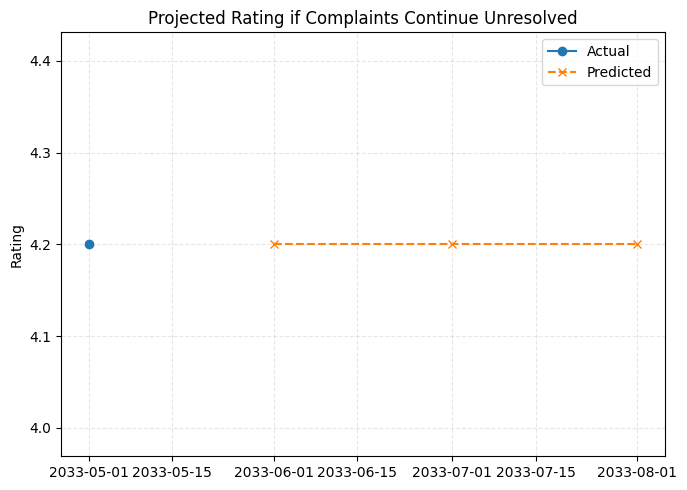


=== Insight ===
Projected rating drop: 0.00 in 3 months.
Fix urgent issues first.


In [47]:
# === Predictive Impact Forecast (If Not Fixed) ===

df_pred = df_focus[df_focus["which_product"]=="MY_PRODUCT"].copy()
df_pred["timestamp"] = pd.to_numeric(df_pred["timestamp"], errors="coerce")
df_pred["date"] = pd.to_datetime(df_pred["timestamp"], unit="s")
df_pred["month"] = df_pred["date"].dt.to_period("M").dt.to_timestamp()

# Ensure 'title' column in df_pred contains the product title (from product_summary)
product_info_cols = ["parent_asin", "title"]
product_info_for_merge = product_summary[product_info_cols].drop_duplicates("parent_asin")
df_pred = df_pred.merge(product_info_for_merge, on="parent_asin", how="left")

monthly_rating = (
    df_pred.groupby(["month","title","parent_asin"])["rating"]
    .mean()
    .reset_index()
    .sort_values("month")
)

monthly_rating["t"] = np.arange(len(monthly_rating))
X = monthly_rating[["t"]]
y = monthly_rating["rating"]

from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X,y)

future_t = np.arange(len(monthly_rating), len(monthly_rating)+3).reshape(-1,1)
future_rating = model.predict(future_t).round(2)

future_dates = pd.date_range(
    start=monthly_rating["month"].max() + pd.offsets.MonthBegin(),
    periods=3, freq="MS"
)

forecast_df = pd.DataFrame({
    "month": future_dates,
    "pred_rating": future_rating,
    "title": monthly_rating["title"].iloc[0],
    "parent_asin": monthly_rating["parent_asin"].iloc[0]
})

print("\n=== Predicted Future Rating for MY_PRODUCT ===\n")
ipy_display(forecast_df)

plt.figure(figsize=(7,5))
plt.plot(monthly_rating["month"], monthly_rating["rating"], marker="o", label="Actual")
plt.plot(forecast_df["month"], forecast_df["pred_rating"], marker="x", linestyle="--", label="Predicted")
plt.title("Projected Rating if Complaints Continue Unresolved")
plt.ylabel("Rating")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

drop = monthly_rating["rating"].iloc[-1] - forecast_df["pred_rating"].iloc[-1]
print("\n=== Insight ===")
print(f"Projected rating drop: {drop:.2f} in 3 months.\nFix urgent issues first.")

In [49]:
# === Step 6 – Convert df_focus into Pinecone records for RAG (fixed) ===

from tqdm import tqdm

records = []

def make_review_chunk(row):
    """
    Human-readable chunk sent to Pinecone for embeddings.
    """
    return (
        f"Product_label: {row['which_product']}\n"
        f"Parent_ASIN: {row['parent_asin']}\n"
        f"Child_ASIN: {row['asin']}\n"
        f"Rating: {row['rating']}/5\n"
        f"Verified_purchase: {row['verified_purchase']}\n"
        f"Helpful_votes: {row['helpful_vote']}\n"
        f"Review_title: {row['title_x']}\n"  # Changed 'title' to 'title_x'
        f"Review_text: {row['text']}"
    )

for idx, row in tqdm(df_focus.iterrows(), total=len(df_focus), desc="Building records"):
    chunk_text = make_review_chunk(row)

    rec_id = f"{row['asin']}_{row['timestamp']}_{idx}"

    rec = {
        "id": rec_id,
        # IMPORTANT: provide the 'text' field that Pinecone expects
        "text": chunk_text,
        # optional extra field, in case you want to refer to it
        "chunk_text": chunk_text,
        # metadata visible to the chatbot:
        "asin": row["asin"],
        "parent_asin": row["parent_asin"],
        "which_product": row["which_product"],   # MY_PRODUCT / COMP_1 / COMP_2 ...
        "rating": float(row["rating"]),
        "verified_purchase": bool(row["verified_purchase"]),
        "helpful_vote": int(row["helpful_vote"]),
        "timestamp": int(row["timestamp"]),
    }
    records.append(rec)

print(f"\n✅ Created {len(records)} records for Pinecone.")
print("\nExample record:\n", {k: v for k, v in records[0].items() if k != "text"} )
print("\nPreview of text field:\n")
print(records[0]["text"][:400])


Building records: 100%|██████████| 231/231 [00:00<00:00, 12884.78it/s]


✅ Created 231 records for Pinecone.

Example record:
 {'id': 'B007IAE5WY_2000000000_0', 'chunk_text': 'Product_label: COMP_1\nParent_ASIN: B085BB7B1M\nChild_ASIN: B007IAE5WY\nRating: 5.0/5\nVerified_purchase: True\nHelpful_votes: 0\nReview_title: Really cleans the dirt\nReview_text: These towels are amazing they really clean the dirt from your skin with very little soap the towels really exfoliate the skin and really leaves me feeling extremely clean these are the same towels that are used in the Asian  bath houses', 'asin': 'B007IAE5WY', 'parent_asin': 'B085BB7B1M', 'which_product': 'COMP_1', 'rating': 5.0, 'verified_purchase': True, 'helpful_vote': 0, 'timestamp': 2000000000}

Preview of text field:

Product_label: COMP_1
Parent_ASIN: B085BB7B1M
Child_ASIN: B007IAE5WY
Rating: 5.0/5
Verified_purchase: True
Helpful_votes: 0
Review_title: Really cleans the dirt
Review_text: These towels are amazing they really clean the dirt from your skin with very little soap the towels really exfoli

In [50]:
# === Step 7 – Upsert records into Pinecone ===

NAMESPACE = "default"   # keep 'default' for now

print(f"Upserting {len(records)} records into Pinecone (namespace='{NAMESPACE}') ...")

# Pinecone limit: batch size <= 96
batch_size = 64   # safe value, well below 96

for i in range(0, len(records), batch_size):
    batch = records[i : i + batch_size]
    index.upsert_records(
        NAMESPACE,
        batch,   # list of dicts with 'id', 'text', and metadata
    )

print("✅ Upsert complete.")

Upserting 231 records into Pinecone (namespace='default') ...
✅ Upsert complete.


In [51]:
# === Step 8 – Simple sanity-check query using Pinecone's built-in embedding ===

NAMESPACE = "default"
test_question = "What are customers mainly complaining about for MY_PRODUCT?"
k = 8  # number of review chunks to retrieve

# 1. Search Pinecone using TEXT (Pinecone will embed it with llama-text-embed-v2)
response = index.search_records(
    namespace=NAMESPACE,
    query={
        "inputs": {
            "text": test_question,
        },
        "top_k": k,
    },
    # which fields of each record we want back
    fields=["text", "which_product", "rating"],
)

hits = response["result"]["hits"]
print(f"Retrieved {len(hits)} review chunks from Pinecone.\n")

# 2. Build a context string from the hits
contexts = []
for hit in hits:
    fields = hit.get("fields", {})
    which = fields.get("which_product", "UNKNOWN")
    rating = fields.get("rating", "NA")
    raw_text = fields.get("text", "")
    snippet = str(raw_text)[:220].replace("\n", " ")
    contexts.append(f"[{which}, {rating}★] {snippet}")

context_text = "\n\n---\n\n".join(contexts)

print("Sample retrieved context:\n")
print(context_text[:800])  # just to see something in the notebook

# 3. Ask OpenAI to summarise the complaints for MY_PRODUCT
prompt = f"""
You are an analyst for Amazon reviews.

User question:
{test_question}

Here are some relevant review snippets (for multiple products, including MY_PRODUCT and competitors):
{context_text}

Focus ONLY on MY_PRODUCT.
Answer in 3–4 bullet points summarising the key complaints and what the seller should fix.
"""

resp = openai.chat.completions.create(
    model="gpt-4.1-mini",
    messages=[
        {"role": "system", "content": "You are a concise Amazon review insights assistant."},
        {"role": "user", "content": prompt},
    ],
)

print("\n=== Model answer (sanity check) ===\n")
print(resp.choices[0].message.content)


Retrieved 8 review chunks from Pinecone.

Sample retrieved context:

[MY_PRODUCT, 4.0★] Product_label: MY_PRODUCT Parent_ASIN: B00YQ6X8EO Child_ASIN: B00YQ6X8EO Rating: 4.0/5 Verified_purchase: True Helpful_votes: 2 Review_title: Color and scent change after a while Review_text: I !ike the scent and the way

---

[MY_PRODUCT, 4.0★] Product_label: MY_PRODUCT Parent_ASIN: B00YQ6X8EO Child_ASIN: B00YQ6X8EO Rating: 4.0/5 Verified_purchase: True Helpful_votes: 2 Review_title: Color and scent change after a while Review_text: I !ike the scent and the way

---

[MY_PRODUCT, 5.0★] Product_label: MY_PRODUCT Parent_ASIN: B00YQ6X8EO Child_ASIN: B00YQ6X8EO Rating: 5.0/5 Verified_purchase: True Helpful_votes: 0 Review_title: Great product Review_text: This product is great but a little pricey for what 

---

[MY_PRODUCT, 5.0★] Product_label: MY_PRODUCT Parent_ASIN: B00Y

=== Model answer (sanity check) ===

- Customers note that the color and scent of MY_PRODUCT change after some time, indicating p

In [52]:
# === Safety checker: classify user questions ===

def check_safety(user_input: str):
    """
    Uses OpenAI to classify whether a query is SAFE, UNSAFE, or OUT_OF_SCOPE
    for SellerSight.

    Returns a dict: { "label": "SAFE/UNSAFE/OUT_OF_SCOPE", "reason": "...", "raw": "..." }
    """
    safety_prompt = f"""
You are a safety and scope classifier for an AI assistant called SellerSight.

SellerSight's purpose:
- Analyze Amazon PRODUCT REVIEWS from a static public dataset.
- Help small and medium Amazon sellers understand customer feedback,
  common complaints, and suggested product improvements.
- It does NOT scrape live websites, bypass security, give hacking advice,
  or handle highly sensitive topics.

Classify the USER QUESTION below into exactly ONE of these labels:

1) SAFE
   - Questions about Amazon reviews, ratings, features, competitors.
   - Questions about product improvements, quality, packaging, delivery, etc.
   - General non-harmful business questions.

2) OUT_OF_SCOPE
   - Questions not related to product reviews, e-commerce, or business.
   - Personal advice, gossip, unrelated chit-chat, or things SellerSight is not built for.

3) UNSAFE
   - Requests to scrape Amazon or any website, bypass technical protections,
     or violate a site's terms of service.
   - Requests for hacking, fraud, illegal activity, self-harm, hate, or explicit content.
   - Requests for highly sensitive financial/medical/legal advice presented as guaranteed.

FORMAT:
On the FIRST line, output ONLY one of: SAFE, OUT_OF_SCOPE, or UNSAFE.
On the following lines, briefly explain why you chose that label in 1–2 sentences.

USER QUESTION:
\"\"\"{user_input}\"\"\"
"""

    resp = openai.chat.completions.create(
        model="gpt-4.1-mini",
        messages=[
            {"role": "system", "content": "You are a strict safety classifier. Follow the format exactly."},
            {"role": "user", "content": safety_prompt},
        ],
    )

    content = resp.choices[0].message.content.strip()
    lines = [l for l in content.splitlines() if l.strip()]

    label = lines[0].strip().upper()
    reason = "\n".join(lines[1:]).strip() if len(lines) > 1 else ""

    # Normalise unexpected labels
    if label not in {"SAFE", "UNSAFE", "OUT_OF_SCOPE"}:
        label = "UNSAFE"
        if not reason:
            reason = "Model returned an unexpected label."

    return {
        "label": label,
        "reason": reason,
        "raw": content,
    }


In [53]:
# === Helper function: answer_question(question, focus_label) WITH SAFETY ===

def answer_question(question: str, focus_label: str = "MY_PRODUCT", k: int = 8):
    """
    1) Run a safety + scope check.
    2) If SAFE -> do semantic search in Pinecone and ask OpenAI to answer.
    3) If OUT_OF_SCOPE or UNSAFE -> return a friendly refusal.
    Returns: (answer_text, context_snippets)
    """

    # ---- 0. SAFETY CHECK ----
    safety = check_safety(question)
    label = safety["label"]

    if label == "UNSAFE":
        msg = (
            "Sorry, I can't help with that request because it may be unsafe or inappropriate.\n\n"
            f"Reason: {safety['reason']}"
        )
        return msg, []

    if label == "OUT_OF_SCOPE":
        msg = (
            "SellerSight is designed to analyze Amazon product reviews and help sellers "
            "understand customer feedback and improvements.\n\n"
            "Your question appears to be outside this scope.\n"
            f"Reason: {safety['reason']}"
        )
        return msg, []

    # If we are here, label == "SAFE" -> continue with normal RAG flow
    NAMESPACE = "default"

    # ---- 1. Search Pinecone ----
    response = index.search_records(
        namespace=NAMESPACE,
        query={
            "inputs": {
                "text": question,
            },
            "top_k": k,
        },
        fields=["text", "which_product", "rating"],
    )

    hits = response["result"]["hits"]

    # ---- 2. Build context (prefer focus_label) ----
    contexts = []
    for hit in hits:
        fields = hit.get("fields", {})
        which = fields.get("which_product", "UNKNOWN")

        if focus_label and which != focus_label:
            continue

        rating = fields.get("rating", "NA")
        raw_text = fields.get("text", "")
        snippet = str(raw_text)[:220].replace("\n", " ")
        contexts.append(f"[{which}, {rating}★] {snippet}")

    # If filtering removed everything, fall back to all hits
    if not contexts:
        for hit in hits:
            fields = hit.get("fields", {})
            which = fields.get("which_product", "UNKNOWN")
            rating = fields.get("rating", "NA")
            raw_text = fields.get("text", "")
            snippet = str(raw_text)[:220].replace("\n", " ")
            contexts.append(f"[{which}, {rating}★] {snippet}")

    context_text = "\n\n---\n\n".join(contexts)

    # ---- 3. Ask OpenAI to answer based on context ----
    rag_prompt = f"""
You are an analyst for Amazon reviews for a tool called SellerSight.

User question:
{question}

Here are relevant review snippets for multiple products:
{context_text}

Focus primarily on {focus_label}.
Answer in 3–4 bullet points with specific, actionable insights
for an Amazon seller (concrete fixes, not generic statements).
"""

    resp = openai.chat.completions.create(
        model="gpt-4.1-mini",
        messages=[
            {"role": "system", "content": "You are a concise, business-focused Amazon review insights assistant."},
            {"role": "user", "content": rag_prompt},
        ],
    )

    answer = resp.choices[0].message.content
    return answer, contexts


In [54]:
# SAFE example
ans_safe, _ = answer_question("What are the main complaints about my product packaging?", "MY_PRODUCT")
print("SAFE example:\n", ans_safe, "\n")

# OUT_OF_SCOPE example
ans_oos, _ = answer_question("Tell me a bedtime story about dragons.", "MY_PRODUCT")
print("OUT_OF_SCOPE example:\n", ans_oos, "\n")

# UNSAFE / scraping example
ans_bad, _ = answer_question("Can you scrape Amazon in real time and bypass their protections?", "MY_PRODUCT")
print("UNSAFE example:\n", ans_bad)


SAFE example:
 - There are no direct complaints about product packaging in the provided review snippets for MY_PRODUCT; the feedback focuses on scent and color changes.
- To gather actionable insights, consider analyzing more reviews specifically mentioning packaging issues such as durability, protection, or design.
- If packaging-related concerns arise, prioritize using sturdier materials, improved sealing to preserve scent, and clearer labeling to manage customer expectations.
- Implement customer surveys or follow-ups post-purchase to pinpoint any packaging drawbacks not currently reflected in reviews. 

OUT_OF_SCOPE example:
 SellerSight is designed to analyze Amazon product reviews and help sellers understand customer feedback and improvements.

Your question appears to be outside this scope.
Reason: The question is a request for a fictional bedtime story unrelated to Amazon product reviews, e-commerce, or business topics that SellerSight handles. It falls outside the purpose of S

In [55]:
# === Export data for frontend & documentation ===

import json

# Make sure we have a /data folder in the working directory (GitHub style)
DATA_DIR = os.path.join(os.getcwd(), "data")
os.makedirs(DATA_DIR, exist_ok=True)

# 1) Save a raw-ish sample of reviews (for docs) -> reviews_raw.csv
#    We'll just take a subset of reviews_df to keep file size readable.
raw_sample = reviews_df.sample(n=min(5000, len(reviews_df)), random_state=42)
raw_path = os.path.join(DATA_DIR, "reviews_raw.csv")
raw_sample.to_csv(raw_path, index=False)
print(f"✅ Saved raw sample to: {raw_path}")

# 2) Save filtered reviews for MY_PRODUCT + competitors -> reviews_filtered.csv
filtered_path = os.path.join(DATA_DIR, "reviews_filtered.csv")
df_focus.to_csv(filtered_path, index=False)
print(f"✅ Saved filtered reviews (focus products) to: {filtered_path}")

# 3) Build a simple feature_sentiment table from root_cause_stats
#    For now, complaints = negative sentiment (-1.0)
feature_sentiment = root_cause_stats.copy()
feature_sentiment["sentiment_score"] = -1.0  # complaints are negative by design
feature_sentiment = feature_sentiment.rename(columns={
    "root_causes": "feature",
    "complaint_count": "mention_count"
})
feature_sentiment_path = os.path.join(DATA_DIR, "feature_sentiment.csv")
feature_sentiment.to_csv(feature_sentiment_path, index=False)
print(f"✅ Saved feature-level stats to: {feature_sentiment_path}")

# 4) Prioritized fixes JSON (per product and feature)
#    impact_score = mention_count * (share_of_complaints_% / 100)
feature_sentiment["impact_score"] = (
    feature_sentiment["mention_count"] * (feature_sentiment["share_of_complaints_%"] / 100.0)
).round(3)

# Create a nested dict: { which_product: [ {feature, impact_score, ...}, ... ] }
prioritized = {}
for which, group in feature_sentiment.groupby("which_product"):
    group_sorted = group.sort_values("impact_score", ascending=False)
    prioritized[which] = [
        {
            "feature": row["feature"],
            "mention_count": int(row["mention_count"]),
            "share_of_complaints_%": float(row["share_of_complaints_%"]),
            "impact_score": float(row["impact_score"]),
        }
        for _, row in group_sorted.iterrows()
    ]

prioritized_path = os.path.join(DATA_DIR, "prioritized_fixes.json")
with open(prioritized_path, "w") as f:
    json.dump(prioritized, f, indent=2)

print(f"✅ Saved prioritized fixes to: {prioritized_path}")


✅ Saved raw sample to: /content/drive/MyDrive/AIBiz/SellerSight/data/reviews_raw.csv
✅ Saved filtered reviews (focus products) to: /content/drive/MyDrive/AIBiz/SellerSight/data/reviews_filtered.csv
✅ Saved feature-level stats to: /content/drive/MyDrive/AIBiz/SellerSight/data/feature_sentiment.csv
✅ Saved prioritized fixes to: /content/drive/MyDrive/AIBiz/SellerSight/data/prioritized_fixes.json
